# Contents
* Importing Libraries
* Last Week Recap
* Crossover
* Mutation
* Genetic Algorithm
* Solving Knapsack(Genetic Algorithm)
* Solving Knapsack(Brute Force)
* Visualization
* Next Week

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from genetic_utils import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # We can use this function instead of PCA to reduce the dimensionality of our data

# Last Week Recap

Last week, we covered :
* What is Knapsack problem
* How to generate a fake Knapsack problem
* How to design a well-structured chromosome for Knapsack problem
* Population initialization implementation
* How to calculate fitness, for Knapsack problem
* Roulette and Tournament selection implementations

If you didn't read last week contents, you can find it <a href="https://github.com/Computational-Intelligence-Fall18/Computational-Intelligence-Tutorials/blob/master/Week%202%20-%20Intro%20to%20Genetic%20Algorithm%20Operators/Genetic%20Operators.ipynb">here</a>.

# Crossover

## One Point Crossover

![one_point_crossover](figs/one_point_crossover.png)

In [2]:
def one_point_crossover(pop, selection_method, pc) :

    p1 = selection_method(pop)
    p2 = selection_method(pop)
    
    chrom_length = len(p1)
    
    point = np.random.randint(1,chrom_length -1)    

    if np.random.random() < pc :
        c1 = Chromosome(chrom_length)
        c2 = Chromosome(chrom_length)
        for i in range(chrom_length) :
            if i < point :
                c1.genes[i] = p1.genes[i]
                c2.genes[i] = p2.genes[i]
            else :
                c1.genes[i] = p2.genes[i]
                c2.genes[i] = p1.genes[i]
    else :
        c1 = deepcopy(p1)
        c2 = deepcopy(p2)
    
    # Reset fitness of each parent
    c1.reset()
    c2.reset()
    
    return c1, c2    

## Two Point Crossover

![two_point_crossover](figs/two_point_crossover_v1.jpg)

In [3]:
def two_point_crossover(pop, selection_method, pc) :
    
    p1 = selection_method(pop)
    p2 = selection_method(pop)
    
    chrom_length = len(p1)
    
    point1 = np.random.randint(1,chrom_length -1)    
    point2 = np.random.randint(1,chrom_length -1)
    
    if np.random.random() < pc :
        c1 = Chromosome(chrom_length)
        c2 = Chromosome(chrom_length)
    
        for i in range(chrom_length) :
            if i < point1 :
                c1.genes[i] = p1.genes[i]
                c2.genes[i] = p2.genes[i]
            elif i < point2 :
                c1.genes[i] = p2.genes[i]
                c2.genes[i] = p1.genes[i]
            else :
                c1.genes[i] = p1.genes[i]
                c2.genes[i] = p2.genes[i]
    else :
        c1 = deepcopy(p1)
        c2 = deepcopy(p2)
    
    # Reset fitness of each parent
    c1.reset()
    c2.reset()
    
    return c1, c2

## Uniform Crossover

![uniform_crossover](figs/uniform-crossover.png)

In [4]:
def unifrom_crossover(pop, selection_method, pc) :
    p1 = selection_method(pop)
    p2 = selection_method(pop)
    
    chrom_length = len(p1)
    
    mask = np.random.randint(0, 2, chrom_length)

    if np.random.random() < pc :
        c1 = Chromosome(chrom_length)
        c2 = Chromosome(chrom_length)
        for i in chrom_length :
            if mask[i]:
                c1.genes[i] = p2.genes[i]
                c2.genes[i] = p1.genes[i]
            else :
                c1.genes[i] = p1.genes[i]
                c2.genes[i] = p2.genes[i]
    else :
        c1 = deepcopy(p1)
        c2 = deepcopy(p2)
    
    # Reset fitness of each parent
    c1.reset()
    c2.reset()
    
    return c1, c2

# Mutation

## Random Mutation

Complementing each gene of a binary chromosome with probablity of $P_{m}$

In [5]:
def random_mutation(chrom, pm) :
    for i in range(len(chrom)):
        if np.random.random() < pm :
            chrom.genes[i] = not chrom.genes[i]
    return chrom

## Inorder Mutation

Complementing the chosen genes(mutation_points) of a binary chromosome with probablity of $P_{m}$

In [6]:
def inorder_mutation(chrom, pm, mutation_points) :
    for i in mutation_points:
        if np.random.random() < pm :
            chrom.genes[i] = not chrom.genes[i]
    return chrom

# Genetic Algorithm (Genetic Algorithm)

In this section we combine operators which were implemented before and create a whole genetic algorithm as follow :

![genetic_architecture](figs/genetic_architecture.PNG)

In [7]:
def knapsack_genetic_algorithm(pop_size=50, iter_num=10, pm=.4,
                               pc=.3, max_value=30, max_weight=40,
                               items_number=20, seed=0) :
    
    # Creating Arrays for saving the individuals of populations
    pop_config = np.ndarray((iter_num, pop_size), dtype=object)
    best_fitness = float('-inf')
    
    # Creating The Fake Problem
    items, bag = get_fake_knapsack(seed, max_value, max_weight, items_number)
    
    # Initializing the population
    pop = population_init(pop_size, len(items))
    
    # Calculating Fitness of each individual
    for i in range(pop_size) :
        pop[i].fitness = fitness_eval(pop[i], items, bag)
        if best_fitness < pop[i].fitness :
            best_fitness = pop[i].fitness
    
    pop_config[0] = pop
    # Loop : Selection, Crossover, Mutation
    for generation in range(1, iter_num) :
        print('Best fitness in generation {} : {}'.format(generation-1, best_fitness))
        new_pop = np.array([])
        
        # Crossover
        for i in range(int(pop_size/2)) :
            parent1, parent2 = one_point_crossover(pop, roulette_selection, pc)
            new_pop = np.append(new_pop, [parent1, parent2])
        
        # Mutation
        for i in range(pop_size) :
            new_pop[i] = random_mutation(new_pop[i], pm/pop_size)
            
        # Fitness Calculation
        for i in range(pop_size) :
            new_pop[i].fitness = fitness_eval(pop[i], items, bag)
            if best_fitness < pop[i].fitness :
                best_fitness = pop[i].fitness
            
        pop = new_pop
        pop_config[generation] = pop
    
    print('Best fitness in generation {} : {}'.format(iter_num, best_fitness))
    return pop_config, items, bag

# Solving Knapsack(Genetic Algorithm)

In this section you can play with parameters $P_{m}$, $P_{c}$, $iter\_num$, $pop\_size$ to see how changing them will affect the best fitness.

In [47]:
%%time
pop_size = 100
iter_num = 200
pm = 1
pc = 1
items_number=20
generations, items, bag = knapsack_genetic_algorithm(pop_size, iter_num, pm, pc, items_number=items_number)

We have 20 items with weight and values of :
item 0: Weight=>28.60757465489678 Value=>16.464405117819744
item 1: Weight=>21.795327319875874 Value=>18.082901282149315
item 2: Weight=>25.835764522666246 Value=>12.709643980167142
item 3: Weight=>35.67092003128319 Value=>13.127616337880776
item 4: Weight=>15.337660753031109 Value=>28.90988281503088
item 5: Weight=>21.155796790116177 Value=>23.75175114247994
item 6: Weight=>37.02386553170644 Value=>17.04133683281797
item 7: Weight=>3.4851719880616283 Value=>2.1310817459366085
item 8: Weight=>33.30479382191752 Value=>0.6065519232097716
item 9: Weight=>34.800485929872764 Value=>23.344702528495514
item 10: Weight=>31.966342568668942 Value=>29.35855026698292
item 11: Weight=>31.221167051458217 Value=>13.844380867587954
item 12: Weight=>25.596840853100954 Value=>3.5482327760679966
item 13: Weight=>37.786756681983356 Value=>4.300598622271393
item 14: Weight=>16.58647759962094 Value=>15.655449652502151
item 15: Weight=>30.969347577368666 Value=>7.

Best fitness in generation 147 : 233.1802476380153
Best fitness in generation 148 : 233.1802476380153
Best fitness in generation 149 : 233.1802476380153
Best fitness in generation 150 : 233.1802476380153
Best fitness in generation 151 : 233.1802476380153
Best fitness in generation 152 : 233.1802476380153
Best fitness in generation 153 : 233.1802476380153
Best fitness in generation 154 : 233.1802476380153
Best fitness in generation 155 : 233.1802476380153
Best fitness in generation 156 : 233.1802476380153
Best fitness in generation 157 : 233.1802476380153
Best fitness in generation 158 : 233.1802476380153
Best fitness in generation 159 : 233.1802476380153
Best fitness in generation 160 : 245.60747747547182
Best fitness in generation 161 : 245.60747747547182
Best fitness in generation 162 : 245.60747747547182
Best fitness in generation 163 : 245.60747747547182
Best fitness in generation 164 : 245.60747747547182
Best fitness in generation 165 : 245.60747747547182
Best fitness in generatio

# Solving Knapsack(Brute Force)

If you want to know the best fitness of the knapsack problem above, you can use this Brute Force algorithm, but be aware that as the number of items grows its runtime will grow exponentially($O_{(2^n)}$).

In [48]:
def calculate_best(items, bag):
    c = Chromosome(len(items))
    best_ans = float('-inf')
    for i in range(2**len(items)) :
        binary_i = format(i, '0' + str(len(items)) + 'b')
        c.genes = np.array(list(map(lambda j: bool(int(j)), binary_i)))
        fitness = fitness_eval(c, items, bag)
        if fitness > best_ans :
            best_ans = fitness
    return best_ans

In [49]:
%%time
print('Best fitness for Knapsack Problem: {}'.format(calculate_best(items, bag)))

Best fitness for Knapsack Problem: 248.94426625541078
Wall time: 15.8 s


# Visualization

First we will extract the information we needed for visualization :

In [50]:
fitnesses = np.array([list(map(lambda chrom: chrom.fitness, pop)) for pop in generations])
chrom_genes = np.array([list(map(lambda chrom: chrom.genes, pop)) for pop in generations])
genes = chrom_genes.reshape(chrom_genes.shape[0]*chrom_genes.shape[1], items_number)

We can't visualize high dimensional data, so we use <a href="http://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf">PCA</a> to map n-D genes of each chromosome to 2-D data

In [51]:
pca = PCA(n_components=2)
reduced_generations = pca.fit_transform(genes)

## Generations Search Space

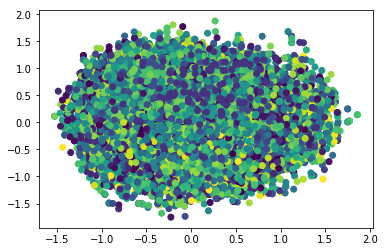

In [52]:
colors = [] # We use colors to differentiate between generations
for i in range(iter_num):
    color = np.random.rand()
    for j in range(pop_size) :
        colors.append(color)

plt.scatter(reduced_generations[:,0], reduced_generations[:,1],c=np.array(colors))

## Animated Generations Search Space

You can see how fitnesses and chromosomes change through different generations in the graph below(Size of each point is corresponding to its fitness):

In [53]:
plot_generations(reduced_generations.reshape(generations.shape[0],generations.shape[1], 2),fitnesses)

# Fitness Value Through Generations

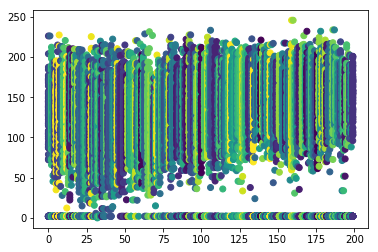

In [54]:
generations_interval = [j for j in range(iter_num) for i in range(pop_size)]
plt.scatter(generations_interval, fitnesses.reshape(fitnesses.shape[0]*fitnesses.shape[1]), c=colors)

As you can see in the graph above, the best fitness value approximately founded in generation 160

# Next Week

Next week, we will implement :
* Crossover Hillclimbing
* Geometrical Crossover
* Uniform Mutation for floating point genes
* Macromutation – Headless Chicken
* How to solve new problem